### 导包

In [1]:
import re # 正则
import emoji # 处理表情
import pandas as pd # 数据处理
import numpy as np # 数学运算
from datetime import datetime # 日期模块
import matplotlib.pyplot as plt # 画图工具
from pyecharts import options as opts # options类
from pyecharts.charts import WordCloud # 云图
from pyecharts.render import make_snapshot # html转png
from snapshot_selenium import snapshot # html转png

### 相关画图参数配置及函数定义

In [2]:
# 函数的作用：在柱状图上标记其数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
# 画图的全局参数配置
plt.rcParams['font.sans-serif'] = ['SimHei'] # 黑体
plt.rcParams['font.size'] = 15 # 字号为15
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时'-'显示为方块的问题

### 前5条数据展示

In [3]:
f=open('./data/清洗后的数据.csv',encoding='utf-8')
df=pd.read_csv(f)
f.close()
df=df.fillna('') # 填充空值
df.head()

,平台,评价id,购买日期,评论日期,用户名,购买手机的配置信息,评价内容,追评内容,追评日期,追评相隔的时间
0,淘宝天猫,1076958484029,2020-03-14 22:06:59,2020-03-16 22:12:38,h***v,网络类型:4G全网通;机身颜色:赤茶橘;套餐类型:官方标配;存储容量:8+256GB,买个妈妈的，她很满意,,,
1,淘宝天猫,1076958220208,2020-03-16 16:03:30,2020-03-16 22:11:19,韦***2,网络类型:4G全网通;机身颜色:亮黑色;套餐类型:官方标配;存储容量:8+256GB,已经买入第二台了 质量真不错,,,
2,淘宝天猫,1077449498185,2020-03-16 19:35:27,2020-03-16 19:38:10,a***g,网络类型:4G全网通;机身颜色:极光色;套餐类型:官方标配;存储容量:8+128GB,发货很快，拍照确实很清楚，通话很清晰，屏幕显示效果很好，手机运行非常不错，已第2次在他家买手...,,,
3,淘宝天猫,1077443646752,2020-03-16 18:40:06,2020-03-16 18:42:03,m***9,网络类型:4G全网通;机身颜色:天空之境;套餐类型:官方标配;存储容量:8+128GB,音质：第二次买了，帮朋友买的，价格降了，产品一样的好，好评！全5分。,,,
4,淘宝天猫,1077185661251,2020-03-16 17:48:26,2020-03-16 17:53:42,k***e,网络类型:4G全网通;机身颜色:亮黑色;套餐类型:官方标配;存储容量:8+128GB,还不错，挺漂亮的，拍照效果杠杠滴，送老公的，快递很快哦，包装很好,,,


### 4月11日开售以来华为p30pro手机的日销量图

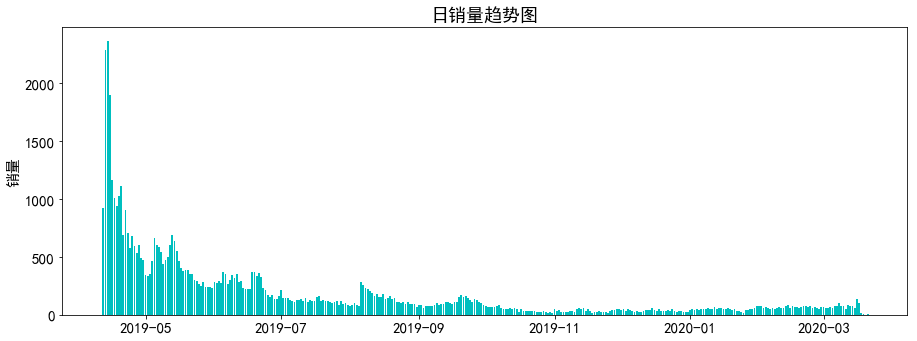

In [4]:
ah=[]
for i in df['评论日期'].values:
    ah.append(re.findall('\d{4}-\d{2}-\d{2}',i)[0])
rq=pd.DataFrame(pd.Series(ah).value_counts().values,pd.Series(ah).value_counts().index).sort_index() # 按日期进行排序
xs = [datetime.strptime(d, '%Y-%m-%d').date() for d in list(rq.index)]
plt.figure(figsize=(13,5))
plt.bar(xs,list(rq[0].values),color='c')
plt.title('日销量趋势图')
plt.ylabel('销量')
plt.tight_layout()
plt.savefig('./data/pictures/日销量趋势图.jpg')
plt.show()

### 不同颜色的手机销量图

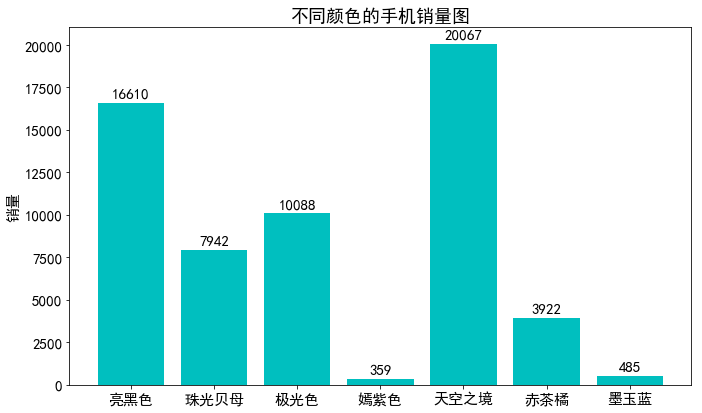

In [5]:
ys=['亮黑色','珠光贝母','极光色','嫣紫色','天空之境','赤茶橘','墨玉蓝']
sku=dict(zip(ys,[int(i) for i in list('0'*len(ys))]))
for i,j in df['购买手机的配置信息'].value_counts().items():
    for y in ys:
        if y in i:
            sku[y]=sku[y]+j
            break
plt.figure(figsize=(10,6))
a=plt.bar(sku.keys(),sku.values(),color='c')
autolabel(a)
plt.ylabel('销量')
plt.title('不同颜色的手机销量图')
plt.tight_layout()
plt.savefig('./data/pictures/不同颜色的手机销量图.jpg')
plt.show()

### 不同配置的手机销量图

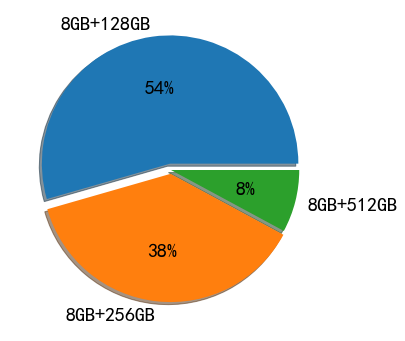

In [6]:
def divice(s):
    if re.search('8GB\+128GB|8\+128GB',s) is not None:
        return '8GB+128GB'
    elif re.search('8GB\+256GB|8\+256GB',s) is not None:
        return '8GB+256GB'
    elif re.search('8GB\+512GB|8\+512GB',s) is not None:
        return '8GB+512GB'
    else:
        return '8GB+128GB'
df1=df['购买手机的配置信息'].apply(lambda s:divice(s))
plt.figure(figsize=(10,5))
explode=(0.05,0.03,0)
plt.pie(df1.value_counts().values,autopct='%.0f%%',labels=df1.value_counts().index,radius=1,
        textprops={'fontsize':20},explode=explode,shadow=True)
plt.tight_layout()
plt.savefig('./data/pictures/不同配置的手机销量占比饼图.jpg')
plt.show()

### 评价内容经过分词后的词云图

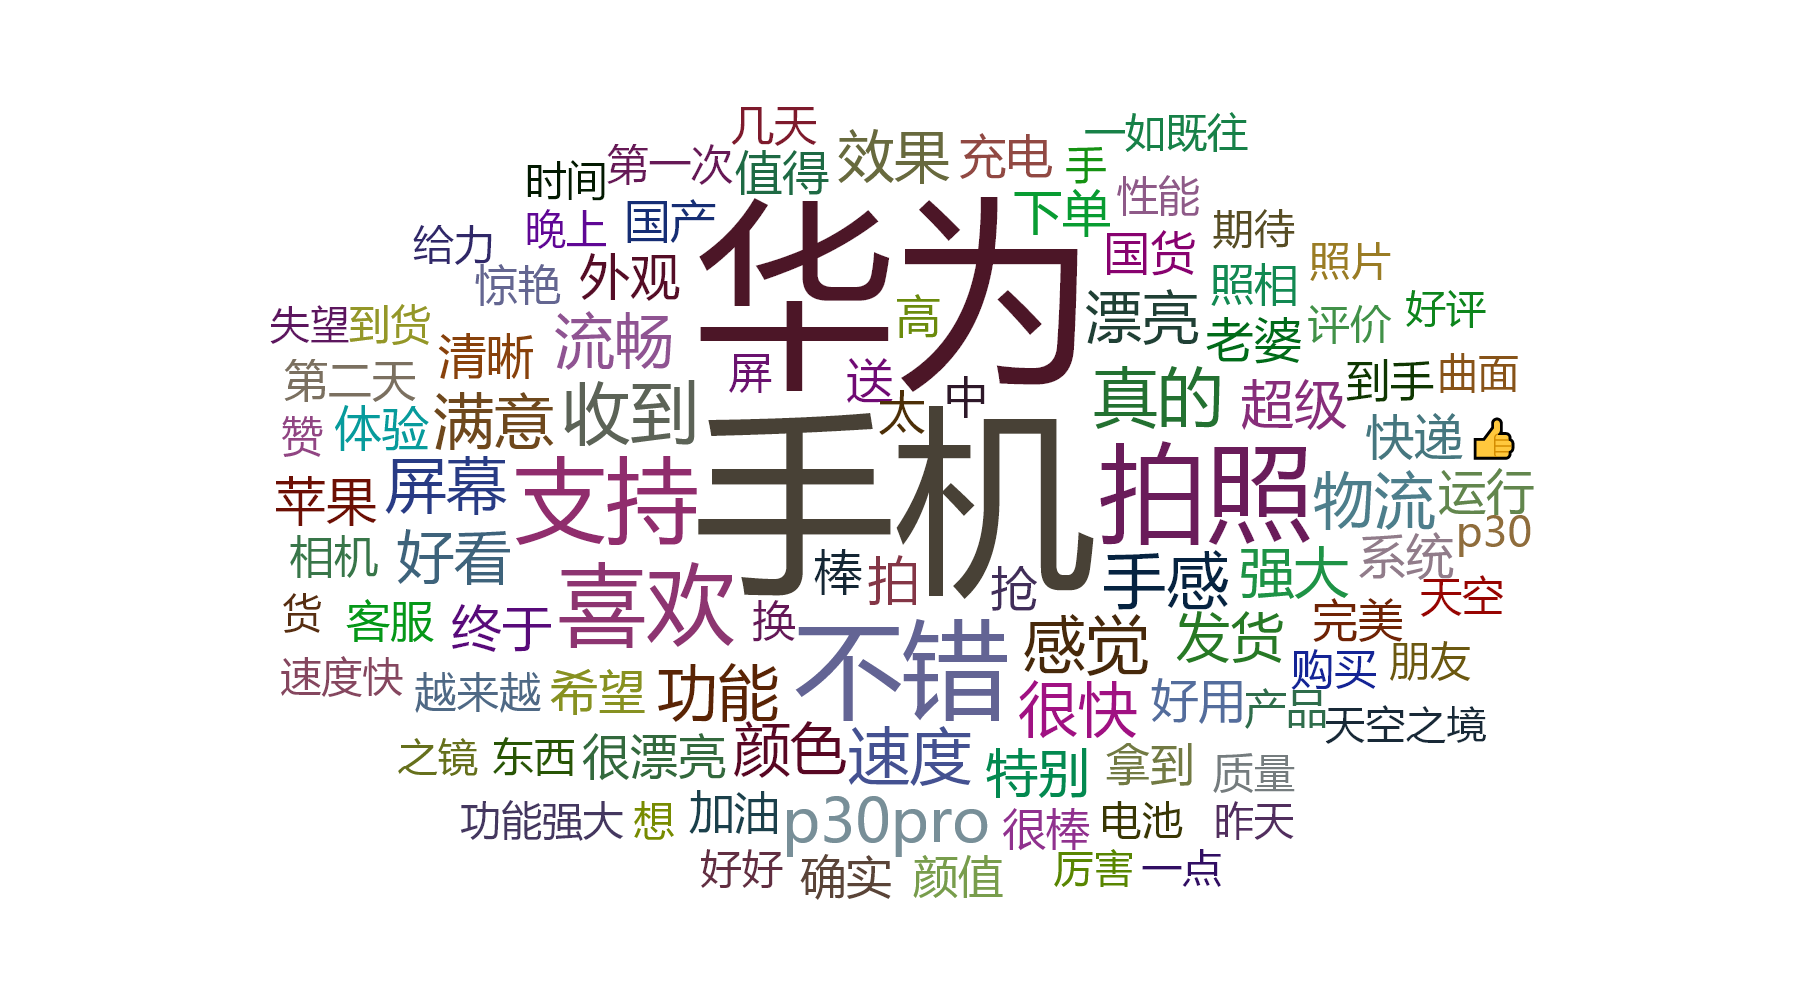

In [7]:
f=open('./data/分词后的评论数据.csv',encoding='utf-8')
all_comments=pd.read_csv(f)
f.close()
all_comments=all_comments.fillna('')
words={}
for i in all_comments['分词处理后的评论'].apply(lambda x:x.split()).values:
    for w in i:
        if w not in words:
            words[w]=1
        else:
            words[w]+=1
words=sorted(words.items(), key=lambda x: x[1], reverse=True)
c=WordCloud()
c.add(series_name="", data_pair=list(words)[:100],word_size_range=[20,100],shape='diamond')
c.set_global_opts(
    title_opts=opts.TitleOpts(
        title="", title_textstyle_opts=opts.TextStyleOpts(font_size=23)
    ),
    tooltip_opts=opts.TooltipOpts(is_show=True),
)
c.render_notebook()

保存词云图

In [8]:
make_snapshot(snapshot,c.render(),'./data/pictures/词云.png',is_remove_html=True)